# Training experiments

This notebook aims at running some training experiments for our ML use case: predicting the `Purchase` target label from the features available and chosen during the data exploration.

More specifically, we will run:
- a linear regression as a baseline
- a random forest
- an XGBoost
- XGBoost with matrix factorization
- CatBoost to easily check feature importances

Then we will try to append an additional preprocessing step: a dimensionality reduction via a matrix factorisation.
<br>_Reason is that such a dimensionality reduction step may help in case of very high cardinalities of categorical features._

__Important note about evaluating the model performances__:
<br>Even if RMSE is used as the main metric to optimise for the models, we do think that calculating more metrics gives a broader picture.
<br>We will focus our reasoning on two main metrics:
- RMSE: advantage is to be expressed in the original unit (great advantage for business purposes) while caveat is to know the entire target label distribution to fully locate the error
- R2: advantage is to lie on a standard scale (like `[0, 1]` or `[-∞, 1]` depending on the implementation - meaning that we do not need to reason with the original target distribution), while caveat is that such metric is dataset dependant (caveat that we overcome by using exactly the same dataset splits).
<br>In all our ML experiments, we will plot the distributions of the model predictions vs. the groundtruth labels in addition to the regular evaluation metrics (RMSE, R2, etc.)
<br>Please take into consideration that the goodness of fit of such distributions is ___NOT___ a sufficient condition to have a perfect model, but remains a __necessary condition__.

## Preprocessing

The following features will be considered as categorical:
- `User_ID`
- `Product_ID`
- `Gender`
- `Age`
- `Occupation`
- `City_Category`
- `Marital_Status`
- `Product_Category_1`
- `Product_Category_2`
- `Product_Category_3`

Such categorical features will have any missing values (originally blank as `null`) filled with the string `missing` via the Sklearn `SimpleImputer`.
<br>They will then be encoded by Sklearn `OneHotEncoder` set to ignore unknown values from training during inference.

We will consider only one feature as numeric: `Stay_In_Current_City_Years`.
<br>Such feature will first be cleaned with a custom-made routine imported via Sklearn `FunctionTransformer`.
<br>Then Sklearn `SimpleImputer` will be applied for any missing value filled in with `-1`.
<br>Caution can be taken that we did not try to standardize the numeric features since we have only one numeric feature with a scale `[-1, 4]`.
<br>Furthermore, from the instructions, we foresee to use ensembles of decision trees, which are non sensitive to different feature scales.


Sklearn `ColumnTransformer` will be used to aggregate both numeric & categorical features into a model of interest - from a linear regression to an XGBoost.



## Baseline model

2022/05/25 19:22:39 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
             ...`
2022/05/25 19:22:39 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                               ...`
2022/05/25 19:22:39 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                ('standardscaler', StandardScaler

Training...


2022/05/25 19:23:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 38.27 s


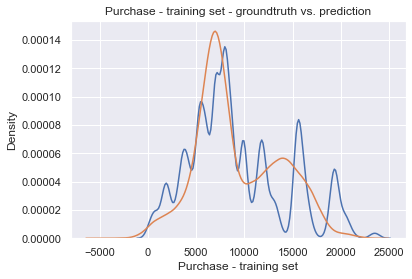

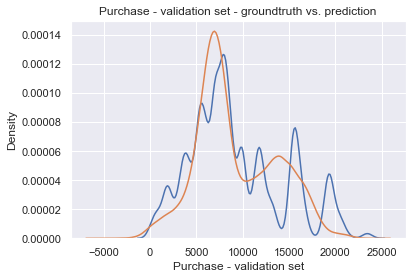

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from pprint import pprint
from modelling.models import (
    get_imputed_preprocessor,
    train_eval
)
from data.data import import_data

# Get training data
X, y = import_data("train.csv")

lin_reg_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", LinearRegression())
    ]),
    model_name="lin_reg_imputed",
    plot_preds=True
)

In [2]:
pprint(valid_perf)

{'MAE': 1852.2647421530846,
 'MedAE': 1398.1242144327034,
 'R2': 0.7528227849236618,
 'RMSE': 2500.4130258111304,
 'explained_variance': 0.7528289190969784,
 'max_error': 16314.210072698974,
 'r2': 0.7528544011269545}


The choice of a train/test split of 70% / 30% is made to fit at best the real conditions: this is the same ratio of training vs. testing examples for which we will have to serve the final model.

Actually using a Linear Regression gives a very good result with an R2 of __0.75__ during the test.
<br>In terms of RMSE, we are at __2500__ for the test performance.

Such baseline may be difficult to beat indeed.

As for the plots, the linear model gives smoother prediction than the groundtruth.
<br>Currently as a sign of underfitting, the model performance can be improved.

#### Comment

Sklearn R2 version (used here) implements the *Nash–Sutcliffe model efficiency coefficient* - denoting a goodness-of-fit indicator that can vary from -∞ to 1.
<br>Having a negative R2 means that the model is worse than a naive one always predicting the mean of the target variable $\bar{y}$.

In the plots, we can see negative values for the `Purchase` variable.
<br>These are just artefacts from the KDE-fitting and they must be discarded.

## Sklearn Random Forest model

2022/05/25 19:24:29 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
             ...`
2022/05/25 19:24:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                               ...`
2022/05/25 19:24:29 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                ('standardscaler', StandardScaler

Training...


2022/05/25 19:25:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 85.07 s


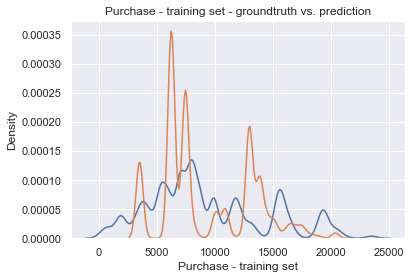

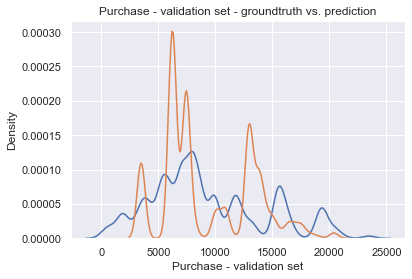

{'MAE': 2326.4638378004306,
 'MedAE': 1932.6604391276578,
 'R2': 0.6405039555304162,
 'RMSE': 3015.467092341872,
 'explained_variance': 0.6405068158086669,
 'max_error': 19997.30394072184,
 'r2': 0.6405068541492803}


In [3]:
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': 30, 'criterion': 'mse', 'max_depth': 10,
    'random_state': 18, 'max_features': 'auto', 'n_jobs': -1
}

rf_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", RandomForestRegressor(**params))
    ]),
    model_name="random_forest_imputed",
    plot_preds=True
)

pprint(valid_perf)

Weirdly the Random Forest does not beat the linear regression, with a test performance of __0.64__ in R2 & __3015__ in RMSE.
<br>It might be due to the hyperparameter values that we have set: a few trees (_30_) and still quite shallow for a Random Forest model (_max_depth_ of 10).

The purpose of such experiments is not to reach the best performance but just to reach some early findings.

In the plots, we can see that the Random Forest actually tries to better fit by giving more granular predictions than the linear regression; however its performance fails to be better.

For tree-based models, it makes semantic sense not to use imputation because they can handle missing values, but with a linear regression. Let’s see if that improves the result.

In [4]:
from modelling.models import get_preprocessor_without_imputation


rf_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_preprocessor_without_imputation()),
        ("regressor", RandomForestRegressor(**params))
    ]),
    model_name="random_forest_without_imputation",
    plot_preds=False
)

pprint(valid_perf)

2022/05/25 19:27:08 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>))]),
           ...`
2022/05/25 19:27:08 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>))]),
                             ...`
2022/05/25 19:27:08 WARNING mlflow.utils: Truncated the value of the key `preprocessor__transformers`. Truncated value: `[('num', Pipeline(steps=[('clean',
                 FunctionTransformer(func=<function clean at 0x000001B492162798>))]), [6]), ('cat', Pipeline(steps=[('cast',
        

Training...


2022/05/25 19:28:08 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 62.31 s
{'MAE': 2326.46048320075,
 'MedAE': 1932.660439127656,
 'R2': 0.6405049254739648,
 'RMSE': 3015.4630243766333,
 'explained_variance': 0.6405077835551111,
 'max_error': 19997.30394072184,
 'r2': 0.6405078223815286}


Almost nothing is affected by omitting imputation. Let's keep it for compatibility reasons.

## XGBoost

2022/05/25 19:28:18 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
             ...`
2022/05/25 19:28:18 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                               ...`
2022/05/25 19:28:18 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
 

Training...


2022/05/25 19:28:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 31.67 s


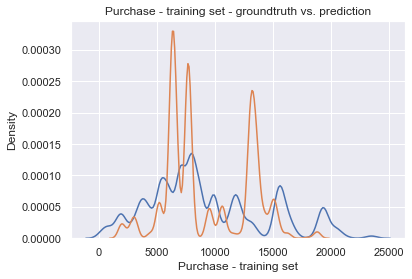

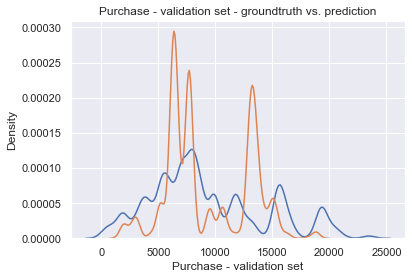

{'MAE': 2302.494407544745,
 'MedAE': 1836.7939453125,
 'R2': 0.6451306803393648,
 'RMSE': 2995.9996772628415,
 'explained_variance': 0.6451321693166268,
 'max_error': 14157.611328125,
 'r2': 0.6519619688979406}


In [5]:
from xgboost import XGBRegressor
from multiprocessing import cpu_count

params = {
    'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0,
    'random_state': 0, 'n_jobs': cpu_count()
}

xgb_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", XGBRegressor(**params))
    ]),
    model_name="xgb_imputed",
    plot_preds=True
)
pprint(valid_perf)

The same remark formulated for the Random Forest model stands for the XGBoost one.
<br>The XGBoost actually underperforms compared to the linear regression baseline, with a test performance of __0.65__ in R2 & __2995__ in RMSE.

In the plots, we can see that the XGBoost tries to better fit by giving more granular predictions than the linear regression, and even more detailed ones than the Random Forest;  however still its performance fails to be better than the baseline.

## Matrix Factorisation + XGBoost

In [6]:
from sklearn.decomposition import TruncatedSVD

SVD_params = {
    'n_components': 100, 'random_state': 0
}

XGB_params = {
    'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0,
    'random_state': 0, 'n_jobs': cpu_count()
}

reduced_xgb_model, valid_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("reductor", TruncatedSVD(**SVD_params)),
        ("regressor", XGBRegressor(**XGB_params))
    ]),
    model_name="reduced_xgb_imputed",
    plot_preds=False
)
pprint(valid_perf)

2022/05/25 19:29:52 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
             ...`
2022/05/25 19:29:52 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x000001B492162798>)),
                               ...`
2022/05/25 19:29:52 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
 

Training...


2022/05/25 19:35:48 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 356.89 s
{'MAE': 2256.63546051762,
 'MedAE': 1706.8095703125,
 'R2': 0.6559286044011243,
 'RMSE': 2950.066594453702,
 'explained_variance': 0.655931148352041,
 'max_error': 16209.4453125,
 'r2': 0.659792613591101}


The dimensionality reduction boosts a little the performances, but not significantly.
<br>The reduced XGBoost does not beat the baseline, with a test performance of __0.65__ in R2 & __2969__ in RMSE.

In terms of plots, we can see that the reduced XGBoost tries to better fit by giving more granular predictions than the linear regression, and less off predictions than the XGBoost alone; however still its performance fails to be better than the baseline.

## General observations

All the results above are very similar with the ones of the initial notebook.
<br>For some models the performances are slightly higher; for those other ones, slightly lower. In any case the differences are not significant.

We may then ask about the relevance of the features `Product_Category_2` & `Product_Category_3` for the modeling task.

To answer this question, let's retrieve the feature importances.

## Feature importances

Let's use a Catboost regressor to extract the feature importances.

Catboost models are user-friendly in the way that they extract a single value for each categorical feature.
<br>On the contrary, models from Sklearn or XGBoost give as many features importances as the number of distinct categories of a variable, which is not convenient.

In [7]:
from catboost import CatBoostRegressor
from data.data import categorical_features, clean, cast

params = {
    "cat_features": categorical_features,
    "n_estimators": 100, "learning_rate": 0.1, "max_depth": 3, "subsample": 1.0,
    "random_state": 0, "verbose": 20
}

X_catboost = clean(X.copy())
X_catboost = cast(X_catboost)

catboost_model, valid_perf = train_eval(
    X=X_catboost,
    y=y,
    model=CatBoostRegressor(**params),
    model_name="catboost",
    model_params=params,  # MLFlow autologging if not available for Catboots
    plot_preds=False
)

pprint(valid_perf)

Training...
0:	learn: 4730.9606920	total: 294ms	remaining: 29.1s
20:	learn: 2930.3915425	total: 3.29s	remaining: 12.4s
40:	learn: 2769.4506335	total: 5.68s	remaining: 8.17s
60:	learn: 2730.9839032	total: 7.94s	remaining: 5.08s
80:	learn: 2715.5917074	total: 10.1s	remaining: 2.36s
99:	learn: 2704.5311501	total: 12.1s	remaining: 0us
   Training time: 15.09 s
{'MAE': 1985.120052850289,
 'MedAE': 1524.50688746606,
 'R2': 0.7204608817418823,
 'RMSE': 2659.064247615926,
 'explained_variance': 0.7204622558398843,
 'max_error': 14739.06594727969,
 'r2': 0.7205220038024011}


In [8]:
from data.data import features
from modelling.models import get_feature_importances

get_feature_importances(catboost_model, features)

,importance,index_position
Product_Category_1,83.151327,8.0
Product_ID,12.661349,1.0
User_ID,3.082565,0.0
Product_Category_2,0.870405,9.0
Product_Category_3,0.104592,10.0
City_Category,0.074029,5.0
Gender,0.029640,2.0
Age,0.026092,3.0
Occupation,0.000000,4.0
Stay_In_Current_City_Years,0.000000,6.0


Even if the contributions of `Product_Category_2` & `Product_Category_3` are not significant, they are not the less informative features.

Then we need to consider using them in the rest of this demonstration.

## Compare models

Compare the models in the MLFlow user interface.


<img src="../imgs/mlflow.png" />


So far, linear regression performs best. However, XGBoost is not far behind, but many untapped hyperparameters for this model have not yet been set. In the next notebook, we will optimize these hyperparameters.

## Model performance over time

Use EvidentlyAI to track the performance of a trained model.

Create predictions for both train and test datasets. Use the best models so far, which was the linear regression.

In [10]:
import numpy as np
from data.data import import_data, target_label
from sklearn.model_selection import train_test_split

# We need the correct labels to evaluate model performance over time
# Use the same train-valid split as before
ref_data, ref_target = import_data("train.csv")
ref_data, prod_data, ref_target, prod_target = train_test_split(
    X, y, test_size=0.3, random_state=0
)

ref_data["prediction"] = lin_reg_model.predict(ref_data)
prod_data["prediction"] = lin_reg_model.predict(prod_data)
ref_data[target_label] = ref_target
prod_data[target_label] = prod_target

In [11]:
from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import RegressionPerformanceTab

from data.data import target_label, numeric_features, categorical_features

column_mapping = ColumnMapping(
    target_label,
    "prediction",
    numerical_features=numeric_features,
    # Evindently is still is beta, it can handle categorical variables which have numeric types ...
    categorical_features=ref_data[categorical_features].select_dtypes(include=np.number).columns.values.tolist()
)

Take a look at the model performance dashboard.

In [12]:
dashboard = Dashboard(tabs=[RegressionPerformanceTab(verbose_level=1)])
dashboard.calculate(ref_data.sample(5000, random_state=0), prod_data.sample(5000, random_state=0), column_mapping=column_mapping)
dashboard.save("model_perf_dashboard.html")

Evidently is still is beta, so dashboards might not show up correctly in Jupyter. We have picked the most interesting plots from Evidently's Model Performace Dashboard:


<img src="../imgs/predicted_vs_actual.JPG" />
<img src="../imgs/error_distribution.JPG" />
<img src="../imgs/prod_1_error_bias.png" />
<img src="../imgs/prod_1_predicted_vs_actual.png" />


We can observe that the distribution of the data in the valid set is very similar to the training set. With the help of such diagrams, it is easier to detect if a model is no longer performing so well on the new data. We can also follow the changes over time. It can point out how the data actually fed differs from what the model has seen at training time.

In [13]:
import mlflow

mlflow.log_artifact("model_perf_dashboard.html")